## Trabajo Diabetes
### 
#### 


In [1]:
# Cargamos librerias y seteos iniciales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.cluster import DBSCAN
from mpl_toolkits import mplot3d
from sklearn.cluster import AgglomerativeClustering

plt.rcParams["figure.figsize"] = (15, 8)
sns.set(style="darkgrid", font_scale=1)

Funciones auxiliares para calcular y mostrar matrices de confusion cuando el numero de clases difiere  
(Al final no fueron necesarias)

In [2]:
# funcion para obtener los valore unicos de una lista
def unique(list):

    # creamos una lista vacia
    unique_list = []
    
    # recorremos los elementos de la lista
    for x in list:
        # Vemos si el elemento ya esta en la salida
        if x not in unique_list:
            # Si no esta, lo agregamos
            unique_list.append(x)
    # devolvemos la lista        
    return(unique_list)


In [3]:
def rect_conf_matrix(real, pred):
    '''
    Esta funcion recibe dos series panda y calcula la matriz de confusion
    Aunque difieran en numero de clases
    Devuelve un np array para dibujar con confusionMatrixDisplay
    '''
    #Convertimos las series panda a listas
    l_real = real.values.tolist()
    l_pred = pred.values.tolist()
    n_real = len(l_real)
    n_pred = len(l_pred)
    uni_real = unique(l_real)
    uni_pred = unique(l_pred)
    # inicializamos el array de salida
    salida = [ [ 0 for y in range( len(uni_pred)  ) ]  for x in range( len(uni_real)  ) ]
    # si las series tienen distinta longitud rompemos
    if n_pred != n_real:
        raise Exception('Las series deben tener la misma longitud')
    # Ahora recorremos las listas    
    for indice in range(n_pred): 
        # tomamos los valores de las listas como indices del array de salida
        # Como deben empezar en 0 restamos 1
        i_real = l_real[indice] - 1
        i_pred = l_pred[indice] - 1
        # DEBUG!!!
        #        print(i_real," ", i_pred, " ", salida[i_real][i_pred])
        # usamos esos indices y vamos actualizando el array sumando 1 cada vez
        salida[i_real][i_pred] = salida[i_real][i_pred] + 1
    # convertimos a array numpy
    resultado = np.array(salida)
    # Devolvemos lo calculado
    return(resultado)             

[[1 0 0 1]
 [0 2 0 0]
 [1 0 2 1]
 [0 0 0 0]]


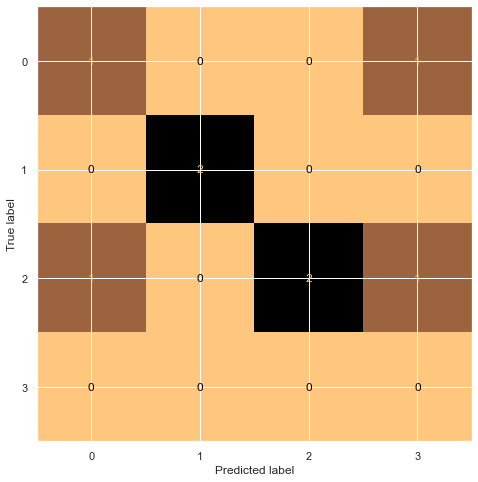

In [4]:
# prueba
data1 = np.array([1, 2, 3, 3, 3, 2, 3, 1])
data2 = np.array([1, 2, 3, 4, 1, 2, 3, 4])

ser1 = pd.Series(data1)
ser2 = pd.Series(data2)

conf_ori = confusion_matrix(data1,data2)


print(conf_ori)
disp_ori = ConfusionMatrixDisplay(confusion_matrix=conf_ori)
disp_ori.plot(values_format='d', colorbar=False, cmap='copper_r');
# plt.tick_params(axis=u'both', which=u'both',length=0)

In [5]:

# Leemos el dataset
# data extraida de https://data.mendeley.com/datasets/wj9rwkp9c2/1

# Numero de Paciente, 
# Edad, 
# Genero
# Creatinina(Cr), 
# Indice de masa corporal (BMI), 
# Urea, 
# Colesterol Total, 
# LDL, 
# VLDL, 
# Trigliceridos(TG) 
# HDL Colesterol de Alta densidad , 
# HBA1C Hemoglobina Glicosilada
# Class (Si tiene diabetes, si no y si el medico "predice" que va a tener diabetes)

df = pd.read_csv('./diabetes_2.csv')

# Reemplazamos posibles valores vacios por NaN
df = df.replace('',np.nan)



# Mostramos el dataset
df

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,200,454317,M,71,11.0,97,7.0,7.5,1.7,1.2,1.8,0.6,30.0,Y
996,671,876534,M,31,3.0,60,12.3,4.1,2.2,0.7,2.4,15.4,37.2,Y
997,669,87654,M,30,7.1,81,6.7,4.1,1.1,1.2,2.4,8.1,27.4,Y
998,99,24004,M,38,5.8,59,6.7,5.3,2.0,1.6,2.9,14.0,40.5,Y


In [6]:
# Como hay algunos datos categoricos (Gender y Class)
# los vamos a convertir a numericos
df.Gender.unique()
df.CLASS.unique()

# copiamos los valores de CLASS a una nueva columna
df['CLASS_3'] = df['CLASS']


# En un diccionario ponemos la conversion ya que el dataset tiene cualquier cosa
dict_reemplazo = {"Gender":     {"F": 0, "M": 1, 'f': 0},
                   "CLASS":     {'N': 0, 'N ': 0, 'P': 1, 'Y': 1, 'Y ': 1},
                   "CLASS_3":   {'N': 0, 'N ': 0, 'P': 1, 'Y': 2, 'Y ': 2}
               }

# Aplicamos el reemplazo en el dataframe
df = df.replace(dict_reemplazo)

# No_Pation y ID no nos sirven para nada, los eliminamos
df.drop(['ID', 'No_Pation'], axis=1, inplace=True)

# Separamos la columna CLASS y CLASS_3
df_class = df['CLASS']
df_class_3 = df['CLASS_3']

# Y ahora removemos esas columna del dataset (es la que vamos a clusterizar)
# f = df.drop('CLASS', inplace=True, axis=1)
del df['CLASS']
del df['CLASS_3']

# vemos que quedo
print(df.shape)
df
#df.dtypes

(1000, 11)


,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0
2,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
3,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
4,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0
...,...,...,...,...,...,...,...,...,...,...,...
995,1,71,11.0,97,7.0,7.5,1.7,1.2,1.8,0.6,30.0
996,1,31,3.0,60,12.3,4.1,2.2,0.7,2.4,15.4,37.2
997,1,30,7.1,81,6.7,4.1,1.1,1.2,2.4,8.1,27.4
998,1,38,5.8,59,6.7,5.3,2.0,1.6,2.9,14.0,40.5


### Analisis exploratorio

In [7]:
# Vemos informacion del dataset
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  1000 non-null   int64  
 1   AGE     1000 non-null   int64  
 2   Urea    1000 non-null   float64
 3   Cr      1000 non-null   int64  
 4   HbA1c   1000 non-null   float64
 5   Chol    1000 non-null   float64
 6   TG      1000 non-null   float64
 7   HDL     1000 non-null   float64
 8   LDL     1000 non-null   float64
 9   VLDL    1000 non-null   float64
 10  BMI     1000 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 86.1 KB


In [8]:
nombres = list(df.columns)
print(nombres)

['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']


In [9]:
# Listamos los datos que son NaN
df.isna().sum()

Gender    0
AGE       0
Urea      0
Cr        0
HbA1c     0
Chol      0
TG        0
HDL       0
LDL       0
VLDL      0
BMI       0
dtype: int64

In [10]:
# Veamos como se distribuyen los datos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,1000.0,0.565000,0.496005,0.0,0.0,1.0,1.0,1.00
AGE,1000.0,53.528000,8.799241,20.0,51.0,55.0,59.0,79.00
Urea,1000.0,5.124743,2.935165,0.5,3.7,4.6,5.7,38.90
Cr,1000.0,68.943000,59.984747,6.0,48.0,60.0,73.0,800.00
HbA1c,1000.0,8.281160,2.534003,0.9,6.5,8.0,10.2,16.00
Chol,1000.0,4.862820,1.301738,0.0,4.0,4.8,5.6,10.30
TG,1000.0,2.349610,1.401176,0.3,1.5,2.0,2.9,13.80
HDL,1000.0,1.204750,0.660414,0.2,0.9,1.1,1.3,9.90
LDL,1000.0,2.609790,1.115102,0.3,1.8,2.5,3.3,9.90
VLDL,1000.0,1.854700,3.663599,0.1,0.7,0.9,1.5,35.00


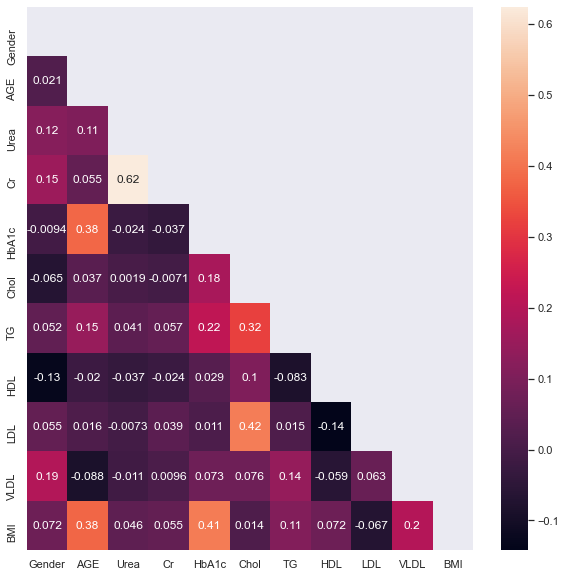

In [11]:
# Vamos a hacer una matriz de correlacion para ver si todo tiene logica
corr = df.corr()
plt.figure(figsize=(10,10))
mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask,annot=True)
plt.show()

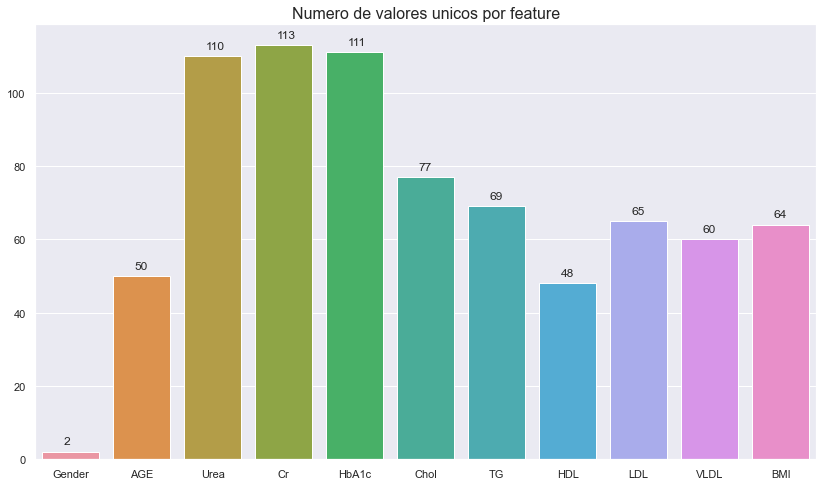

In [12]:
# Ahora veamos la cantidad de datos unicos por feature
plt.figure(figsize=(14,8))
x = list(df.nunique().index)
y = df.nunique().values
for i in range(len(x)):
        plt.text(i-.1,y[i]+2,str(y[i]))
plt.title("Numero de valores unicos por feature",fontdict={"fontsize":16})
sns.barplot(x = x,y = y)
plt.show();

In [13]:
# Normalizamos todo el dataset
df_normal=(df - df.mean()) / df.std()
df_normal


,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
0,-1.139101,-0.400944,-0.144708,-0.382481,-1.334316,-0.509181,-1.034567,1.809851,-1.084914,-0.369773,-1.124060
1,0.877007,-3.128452,-0.212848,-0.115746,-1.334316,-0.893283,-0.677724,-0.158613,-0.457169,-0.342477,-1.325575
2,-1.139101,-0.400944,-0.144708,-0.382481,-1.334316,-0.509181,-1.034567,1.809851,-1.084914,-0.369773,-1.124060
3,-1.139101,-0.400944,-0.144708,-0.382481,-1.334316,-0.509181,-1.034567,1.809851,-1.084914,-0.369773,-1.124060
4,0.877007,-2.332928,0.672963,-0.382481,-1.334316,0.028562,-0.963198,-0.612874,-0.546847,-0.397069,-1.728607
...,...,...,...,...,...,...,...,...,...,...,...
995,0.877007,1.985626,2.001678,0.467736,-0.505587,2.025892,-0.463618,-0.007192,-0.726203,-0.342477,0.085036
996,0.877007,-2.560221,-0.723892,-0.149088,1.585965,-0.586001,-0.106775,-0.764294,-0.188135,3.697266,1.535950
997,0.877007,-2.673867,0.672963,0.201001,-0.623977,-0.586001,-0.891829,-0.007192,-0.188135,1.704690,-0.438906
998,0.877007,-1.764698,0.230058,-0.165759,-0.623977,0.335843,-0.249512,0.598489,0.260254,3.315128,2.200952


In [14]:
# Correlacion entre features
df.corr()

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
Gender,1.000000,0.021486,0.116311,0.154870,-0.009362,-0.064763,0.052111,-0.130130,0.054563,0.194120,0.072097
AGE,0.021486,1.000000,0.105092,0.054941,0.379136,0.036649,0.148204,-0.020038,0.016105,-0.087903,0.375956
Urea,0.116311,0.105092,1.000000,0.624134,-0.023603,0.001852,0.040980,-0.036994,-0.007301,-0.011191,0.045618
Cr,0.154870,0.054941,0.624134,1.000000,-0.037412,-0.007097,0.056579,-0.023804,0.039479,0.009615,0.054746
HbA1c,-0.009362,0.379136,-0.023603,-0.037412,1.000000,0.177489,0.218556,0.028933,0.011057,0.073462,0.413350
Chol,-0.064763,0.036649,0.001852,-0.007097,0.177489,1.000000,0.321789,0.103814,0.416665,0.076294,0.013678
TG,0.052111,0.148204,0.040980,0.056579,0.218556,0.321789,1.000000,-0.083001,0.015378,0.144570,0.110757
HDL,-0.130130,-0.020038,-0.036994,-0.023804,0.028933,0.103814,-0.083001,1.000000,-0.142079,-0.059275,0.072409
LDL,0.054563,0.016105,-0.007301,0.039479,0.011057,0.416665,0.015378,-0.142079,1.000000,0.062795,-0.067322
VLDL,0.194120,-0.087903,-0.011191,0.009615,0.073462,0.076294,0.144570,-0.059275,0.062795,1.000000,0.198133


In [15]:
# Veamos como afecta cada variable original a cada componente PCA
# Ojo con el indice de las PCA en este dataframe
pca = PCA()
pca.fit(df_normal)

cargas = pd.DataFrame(pca.components_.T,
                    columns=['PC%s' % _ for _ in range(len(df.columns))],
                    index=df_normal.columns)
cargas


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Gender,0.142559,0.272030,0.077481,0.527923,-0.005023,-0.214999,0.742511,-0.117497,-0.028232,0.093533,0.006862
AGE,0.433690,-0.082192,-0.287048,-0.148765,-0.386216,-0.098521,0.148510,0.556709,0.426417,0.068572,-0.152468
Urea,0.212922,0.615750,-0.028198,-0.230932,0.056431,0.037359,-0.137394,-0.042168,0.128974,0.332433,0.607462
Cr,0.209509,0.626497,0.011938,-0.191000,0.098762,-0.002602,-0.101955,-0.081112,-0.083292,-0.346784,-0.610780
HbA1c,0.476999,-0.262760,-0.174674,-0.039834,-0.077391,-0.028446,-0.046789,-0.746712,0.285703,-0.146256,0.041801
Chol,0.276879,-0.191015,0.545806,-0.307616,0.169722,-0.017083,0.091155,-0.052766,-0.075870,0.596944,-0.303365
TG,0.363888,-0.087081,0.230266,0.028024,0.102082,0.745789,0.198080,0.179818,-0.137655,-0.332955,0.195435
HDL,-0.024489,-0.140404,-0.185429,-0.397463,0.707448,-0.263103,0.338698,0.116590,0.128356,-0.237123,0.128871
LDL,0.130930,-0.033507,0.595132,-0.101944,-0.259427,-0.498741,-0.080772,0.097264,-0.051180,-0.452570,0.278732
VLDL,0.195770,-0.006207,0.176204,0.569293,0.461901,-0.071170,-0.432122,0.186754,0.404248,0.012646,-0.053780


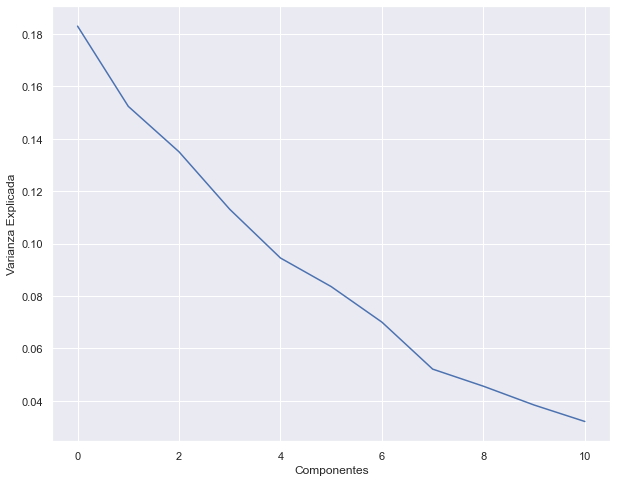

In [16]:
# Porcentaje de varianza por componente en un grafico
plt.figure(figsize=(10,8))
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Varianza Explicada')
plt.xlabel('Componentes')
plt.show()

In [17]:
# Varianza explicada por cada componente
var_pc = pca.explained_variance_ratio_
#print(var_pc)

indice = 1
for var in var_pc:
    print("PCA{:02} : {:05.4f}".format(indice, round(var,4)))
    indice += 1

PCA01 : 0.1830
PCA02 : 0.1524
PCA03 : 0.1351
PCA04 : 0.1131
PCA05 : 0.0945
PCA06 : 0.0836
PCA07 : 0.0700
PCA08 : 0.0521
PCA09 : 0.0456
PCA10 : 0.0384
PCA11 : 0.0321


No handles with labels found to put in legend.


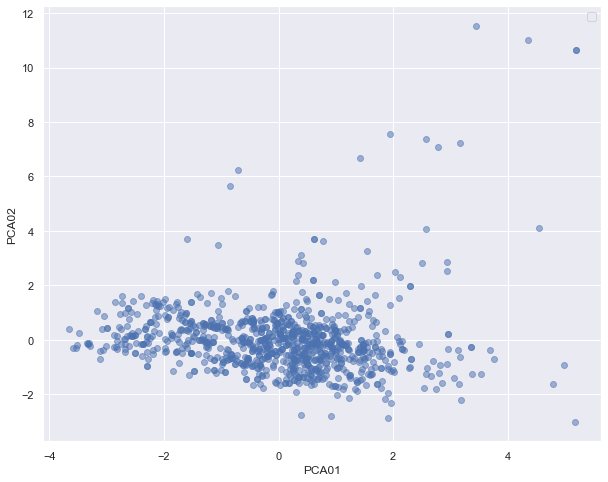

In [20]:
# Graficamos las dos primeras PC
plt.rcParams["figure.figsize"] = (10, 8)
proyectada = pca.fit_transform(df_normal)
scat = plt.scatter(proyectada[:, 0], proyectada[:, 1],
            alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PCA01')
plt.ylabel('PCA02')
plt.legend()
plt.show();

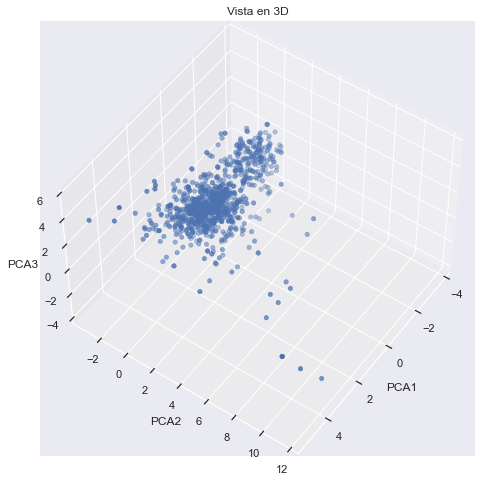

In [21]:
# Veamos con 3 PCA
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(proyectada[:, 0], proyectada[:, 1], proyectada[:, 2], linewidth=0.5, zdir='z',);
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Vista en 3D');
ax.view_init(50, 35)

### Clasificacion No Supervisada

#### Veamos cuantos clusters nos sugiere silhouette

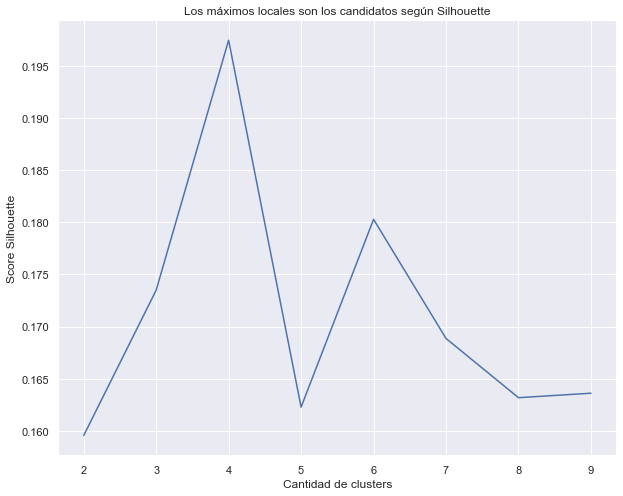

In [22]:
# Regla de silhouette
silhouette_scores = []
rango_clusters = range(2,10)

for i in rango_clusters:
    # para cada valor de i, calculo kmeans y silhouette
    k_means = KMeans(n_clusters=i,random_state=42, n_init=10)
    k_means.fit(df_normal)
    
    sil_score = silhouette_score(df_normal, labels=k_means.labels_)
    silhouette_scores.append(sil_score)

plt.plot(rango_clusters,silhouette_scores)
plt.xticks(rango_clusters)
plt.xlabel('Cantidad de clusters')
plt.ylabel('Score Silhouette')
plt.title('Los máximos locales son los candidatos según Silhouette')
plt.show()

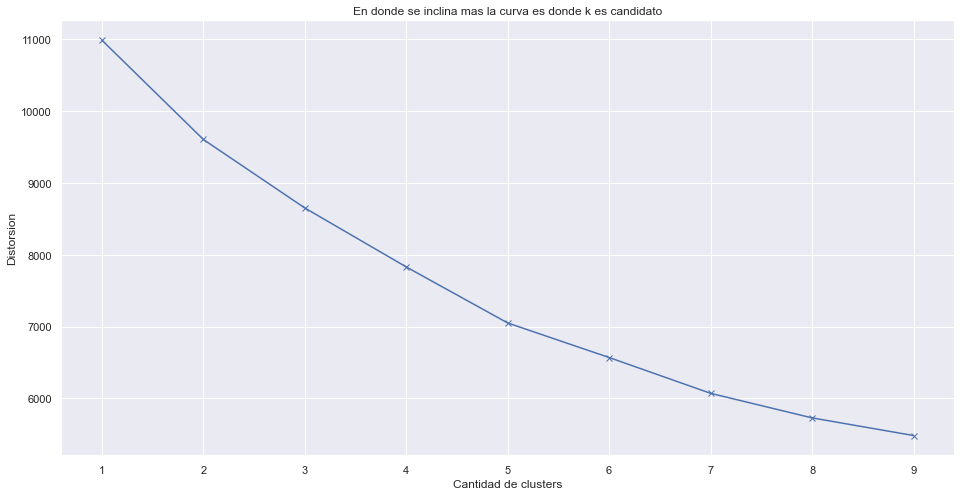

In [23]:
# Regla del baston quebrado
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_normal)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Cantidad de clusters')
plt.ylabel('Distorsion')
plt.title('En donde se inclina mas la curva es donde k es candidato')
plt.show()

In [25]:
cant_clusters=4

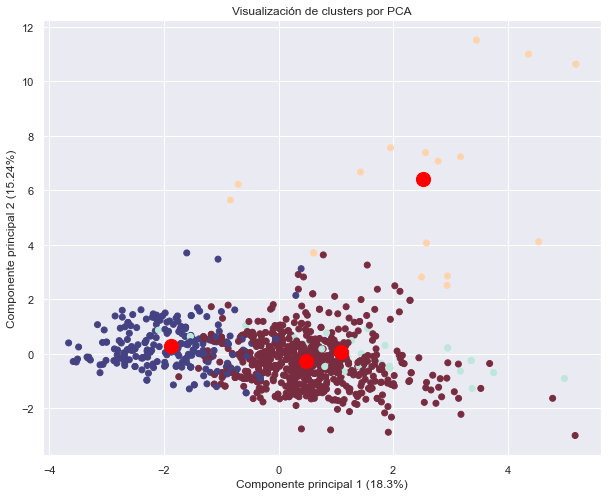

In [34]:
# instanciamos la clase
kmeans = KMeans(n_clusters=cant_clusters, random_state=42)
# entreno al modelo
kmeans.fit(df_normal)
# que me prediga el cluster para cada dato
y_kmeans = pd.Series(kmeans.predict(df_normal))

# que me diga los centroides
centroides = kmeans.cluster_centers_
# transformo los centroides al plano PCA para poderlos graficar
centroides_pca = pca.transform(centroides)

# cálculo varianza explicada
vars = pca.explained_variance_ratio_
var1 = round(100*vars[0],2)
var2 = round(100*vars[1],2)

# grafico en el plano PCA datos, clusters y centroides
plt.scatter(proyectada[:,0],proyectada[:,1], c=kmeans.labels_, cmap="icefire")
plt.scatter(centroides_pca[:,0],centroides_pca[:, 1], c="red", s=200)
plt.xlabel("Componente principal 1 ({}%)".format(var1))
plt.ylabel("Componente principal 2 ({}%)".format(var2))
plt.title("Visualización de clusters por PCA")
#plt.legend()
plt.show()

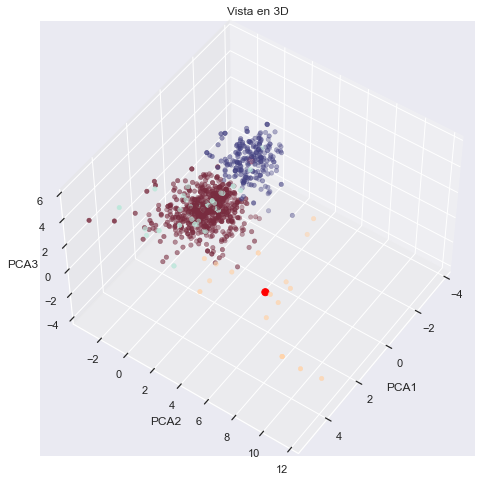

In [62]:
# Veamos con 3 PCA
fig = plt.figure()
ax = plt.axes(projection='3d')
scat_plot = ax.scatter3D(proyectada[:, 0], proyectada[:, 1], proyectada[:, 2], 
             linewidth=0.5, zdir='z',c=kmeans.labels_, cmap="icefire");
scat_cent = ax.scatter(centroides_pca[:,0],centroides_pca[:, 1],centroides_pca[:, 2], c="red", s=50)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Vista en 3D')
#cb = plt.colorbar(scat_plot, pad=0.2)
ax.view_init(50, 35)


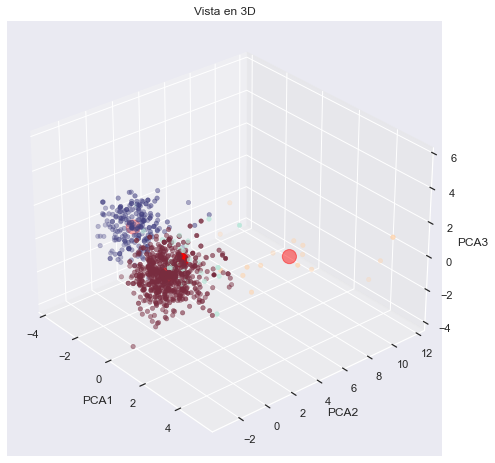

In [63]:
# Veamos con 3 PCA otro angulo
fig = plt.figure()
ax = plt.axes(projection='3d')
scat_cent = ax.scatter(centroides_pca[:,0],centroides_pca[:, 1],centroides_pca[:, 2], c="red", s=200)
scat_plot = ax.scatter3D(proyectada[:, 0], proyectada[:, 1], proyectada[:, 2], 
             linewidth=0.5, zdir='z',c=kmeans.labels_, cmap="icefire");
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Vista en 3D')
#cb = plt.colorbar(scat_plot, pad=0.2)
ax.view_init(30, -40)

In [65]:
# Vamos a ver como se agrupan los cluster sacando su media y desviacion
df_class_kmeans = pd.Series(kmeans.fit_predict(df))

# Agrega una nueva variable con el cluster al que pertenece cada observación
df["Cluster"] = df_class_kmeans

# Calculo la media de cada variable para cada cluster
df.groupby(["Cluster"]).mean()

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
Cluster,,,,,,,,,,,
0,0.748918,53.740260,6.572511,94.069264,7.796104,4.816450,2.284329,1.161169,2.584848,2.140260,29.193290
1,0.666667,54.583333,14.766667,328.750000,7.958333,4.941667,3.400000,1.250000,2.516667,1.883333,31.216667
2,1.000000,58.000000,20.800000,800.000000,9.050000,5.025000,2.225000,1.075000,3.000000,1.000000,33.500000
3,0.504648,53.422311,4.443683,53.211155,8.431023,4.874927,2.353559,1.218088,2.616853,1.771182,29.649097


In [66]:
# Calculo la desviacion variable para cada cluster
df.groupby(["Cluster"]).std()

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
Cluster,,,,,,,,,,,
0,0.434577,10.172943,2.862855,25.712025,2.261595,1.425784,1.376233,0.634441,1.007444,4.053145,4.823542
1,0.492366,9.169696,8.274971,65.318973,1.929417,1.557071,2.344045,0.721740,0.635085,1.747639,4.841081
2,0.000000,1.632993,0.000000,0.000000,0.057735,2.046745,0.861684,0.125831,1.637071,0.382971,1.000000
3,0.500311,8.355603,2.009412,12.399244,2.609952,1.255438,1.387991,0.669123,1.150509,3.567183,5.007550


In [67]:
# Matriz de confusion 2 clases contra kmeans 4 clusters
cf_matriz = confusion_matrix(df_class,kmeans.labels_)
cf_matriz

array([[ 24,   0,   0,  79],
       [207,  12,   4, 674],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0]])

In [68]:
# Matriz de confusion 3 clases originales contra kmeans 4 clusters
cf_matriz = confusion_matrix(df_class_3,kmeans.labels_)
cf_matriz

array([[ 24,   0,   0,  79],
       [ 12,   1,   0,  40],
       [195,  11,   4, 634],
       [  0,   0,   0,   0]])

Probemos con un valor intermedio entre silhouette y la regla del baston

In [69]:
cant_clusters=3

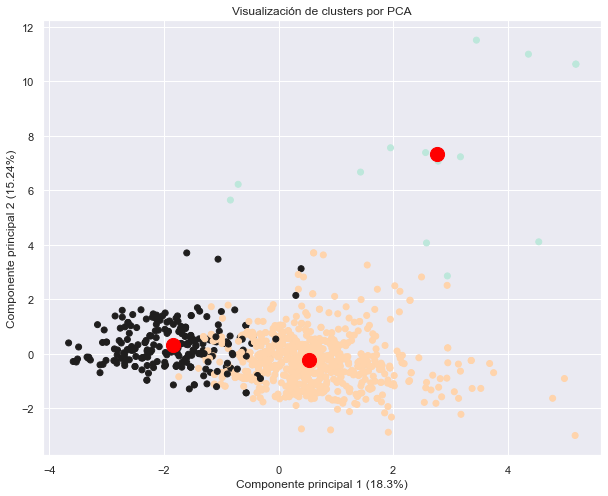

In [70]:
# instancio la clase
kmeans = KMeans(n_clusters=cant_clusters, random_state=42)
# entreno al modelo
kmeans.fit(df_normal)
# que me prediga el cluster para cada dato
y_kmeans = pd.Series(kmeans.predict(df_normal))

# que me diga los centroides
centroides = kmeans.cluster_centers_
# transformo los centroides al plano PCA para poderlos graficar
centroides_pca = pca.transform(centroides)

# cálculo varianza explicada
vars = pca.explained_variance_ratio_
var1 = round(100*vars[0],2)
var2 = round(100*vars[1],2)

# grafico en el plano PCA datos, clusters y centroides
plt.scatter(proyectada[:,0],proyectada[:,1], c=kmeans.labels_, cmap="icefire")
plt.scatter(centroides_pca[:,0],centroides_pca[:, 1], c="red", s=200)
plt.xlabel("Componente principal 1 ({}%)".format(var1))
plt.ylabel("Componente principal 2 ({}%)".format(var2))
plt.title("Visualización de clusters por PCA")
plt.show()

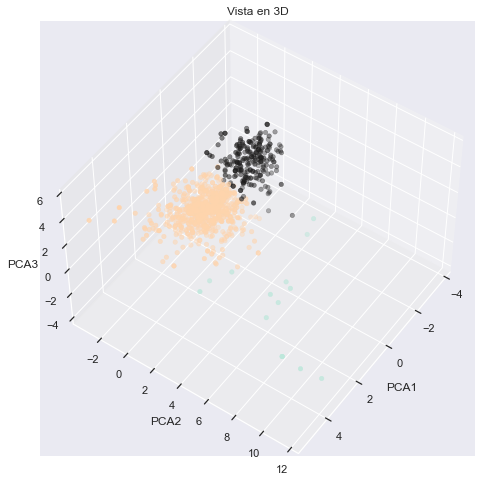

In [71]:
# Veamos con 3 PCA 
fig = plt.figure()
ax = plt.axes(projection='3d')
scat_plot = ax.scatter3D(proyectada[:, 0], proyectada[:, 1], proyectada[:, 2], 
             linewidth=0.5, zdir='z',c=kmeans.labels_, cmap="icefire");
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Vista en 3D')
#cb = plt.colorbar(scat_plot, pad=0.2)
ax.view_init(50, 35)


In [72]:
# Matriz de confusion 2 clases contra kmeans 3 clusters
cf_matriz = confusion_matrix(df_class,kmeans.labels_)
cf_matriz

array([[  1, 100,   2],
       [ 13, 139, 745],
       [  0,   0,   0]])

In [73]:
# Matriz de confusion 3 clases originales contra kmeans 3 clusters
cf_matriz = confusion_matrix(df_class_3,kmeans.labels_)
cf_matriz

array([[  1, 100,   2],
       [  1,  51,   1],
       [ 12,  88, 744]])

### Probamos dbscan

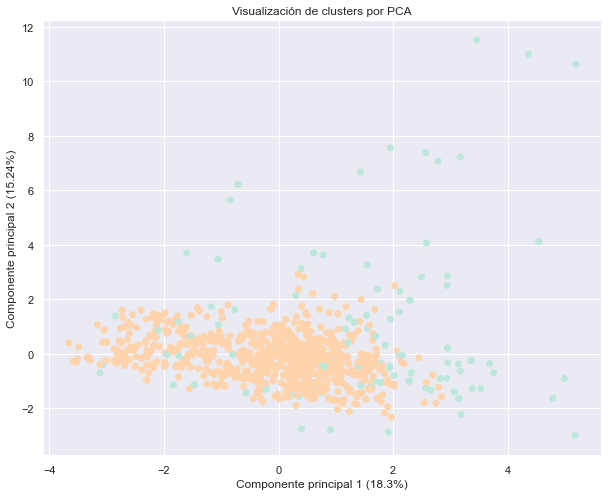

In [74]:
# instanciamos el modelo, con sus parametros por defecto 
dbscan = DBSCAN(eps=2.12, min_samples=10, metric='euclidean' )

# entreno al modelo
dbscan.fit(df_normal)
# que me prediga el cluster para cada dato
y_dbscan = pd.Series(dbscan.fit_predict(df_normal))

# cálculo varianza explicada
vars = pca.explained_variance_ratio_
var1 = round(100*vars[0],2)
var2 = round(100*vars[1],2)

# grafico en el plano PCA datos, clusters y centroides
plt.scatter(proyectada[:,0],proyectada[:,1], c=dbscan.labels_, cmap="icefire")
#plt.scatter(centroides_pca[:,0],centroides_pca[:, 1], c="red", s=200)
plt.xlabel("Componente principal 1 ({}%)".format(var1))
plt.ylabel("Componente principal 2 ({}%)".format(var2))
plt.title("Visualización de clusters por PCA")
plt.show()

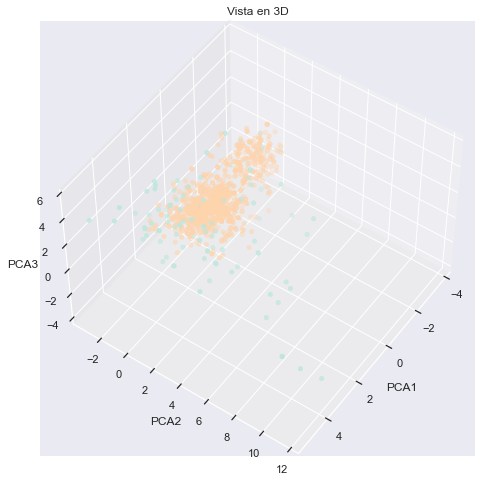

In [75]:
# Veamos con 3 PCA
fig = plt.figure()
ax = plt.axes(projection='3d')
scat_plot = ax.scatter3D(proyectada[:, 0], proyectada[:, 1], proyectada[:, 2], 
             linewidth=0.5, zdir='z',c=dbscan.labels_, cmap="icefire");
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Vista en 3D')
#cb = plt.colorbar(scat_plot, pad=0.2)
ax.view_init(50, 35)


In [76]:
# Matriz de confusion 2 clases contra dbscan
cf_matriz = confusion_matrix(df_class,dbscan.labels_)
cf_matriz

array([[  0,   0,   0],
       [ 14,  89,   0],
       [ 94, 803,   0]])

In [77]:
# Matriz de confusion 3 clases originales contra dbscan
cf_matriz = confusion_matrix(df_class_3,dbscan.labels_)
cf_matriz

array([[  0,   0,   0,   0],
       [ 14,  89,   0,   0],
       [  1,  52,   0,   0],
       [ 93, 751,   0,   0]])

### Probamos con aglomerativo

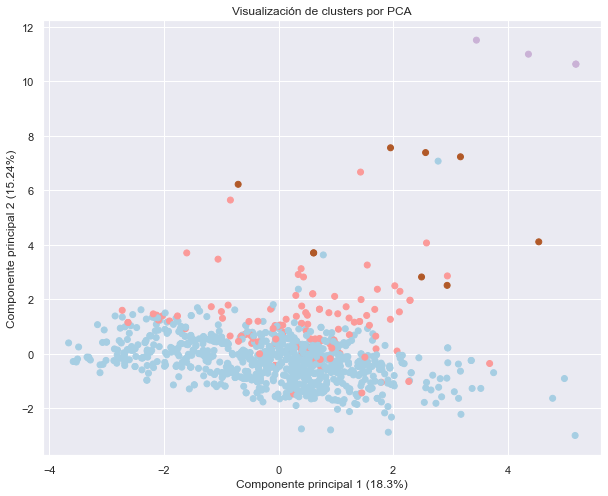

In [78]:
# Probamos aglomerativo con distancia ward, 4 clusters
politica_agrupamiento = ['ward', 'complete', 'average', 'single']
cant_cluster = 4
clustering = AgglomerativeClustering(n_clusters=cant_cluster, linkage=politica_agrupamiento[0])

clustering.fit(df)

y_jerarq = pd.Series(clustering.labels_)


# grafico en el plano PCA datos y clusters
plt.scatter(proyectada[:,0],proyectada[:,1], c=clustering.labels_, cmap="Paired")
# plt.scatter(centroides_pca[:,0],centroides_pca[:, 1], c="red", s=200)
plt.xlabel("Componente principal 1 ({}%)".format(var1))
plt.ylabel("Componente principal 2 ({}%)".format(var2))
plt.title("Visualización de clusters por PCA")
plt.show()

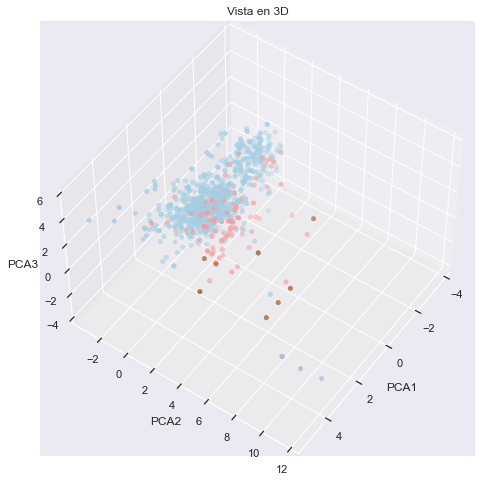

In [79]:
# Veamos con 3 PCA el aglomerativo
fig = plt.figure()
ax = plt.axes(projection='3d')
scat_plot = ax.scatter3D(proyectada[:, 0], proyectada[:, 1], proyectada[:, 2], 
             linewidth=0.5, zdir='z',c=clustering.labels_, cmap="Paired");
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Vista en 3D')
#cb = plt.colorbar(scat_plot, pad=0.2)
ax.view_init(50, 35)


In [80]:
# Matriz de confusion 2 clases contra aglomerativo
cf_matriz = confusion_matrix(df_class,clustering.labels_)
cf_matriz

array([[ 90,  13,   0,   0],
       [778, 106,   4,   9],
       [  0,   0,   0,   0],
       [  0,   0,   0,   0]])

In [81]:
# Matriz de confusion 3 clases originales contra aglomerativo 
cf_matriz = confusion_matrix(df_class_3,clustering.labels_)
cf_matriz

array([[ 90,  13,   0,   0],
       [ 49,   3,   0,   1],
       [729, 103,   4,   8],
       [  0,   0,   0,   0]])